In [1]:
import collections
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, classification_report, roc_auc_score
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier


In [2]:
!pip install spacy
import spacy

In [3]:
#!python -m spacy download en_core_web_lg

In [4]:
nlp = spacy.load('en_core_web_lg')

In [5]:
train = pd.read_csv('/Users/nishabhakar/Downloads/train.csv')
test = pd.read_csv('/Users/nishabhakar/Downloads/test.csv')
sample = pd.read_csv('/Users/nishabhakar/Downloads/sample_submission.csv')


In [6]:
sample

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5
4,00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,0.5,0.5,0.5,0.5,0.5,0.5
153160,fffd7a9a6eb32c16,0.5,0.5,0.5,0.5,0.5,0.5
153161,fffda9e8d6fafa9e,0.5,0.5,0.5,0.5,0.5,0.5
153162,fffe8f1340a79fc2,0.5,0.5,0.5,0.5,0.5,0.5


In [7]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [8]:
target_columns = list(sample.columns.drop('id'))
target_columns

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [9]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [10]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
train[target_columns].sum()

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

In [12]:
train['non-toxic'] = 1-train[target_columns].max(axis=1)

train['toxicity_type_defined'] = train[['insult','obscene','identity_hate','threat']].max(axis=1)

train['toxic_undefined'] = 0
train.loc[(train['toxicity_type_defined']==0)&(train['toxic']==1),'toxic_undefined'] = 1

train['soft_toxic'] = 0
train.loc[(train['toxicity_type_defined']==1)&(train['toxic']==0),'soft_toxic'] = 1

analysis_columns = target_columns + ['non-toxic', 'toxic_undefined', 'soft_toxic']

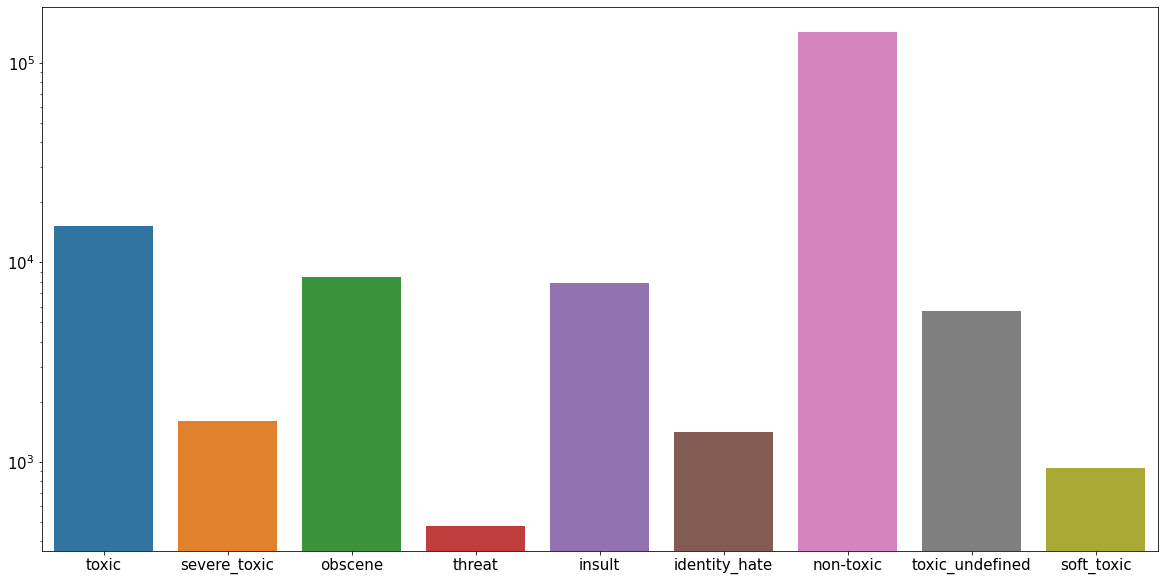

In [13]:
label_counts = train[analysis_columns].sum()
plt.figure(figsize=(20, 10))
ax = sns.barplot(x=label_counts.index, y=label_counts.values)
ax.set_yscale("log")
ax.tick_params(labelsize=15)

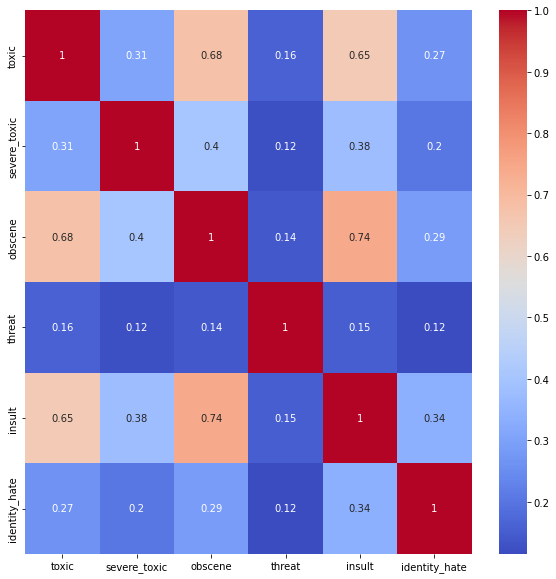

In [14]:
heatmap_data = train[target_columns]
plt.figure(figsize=(10, 10))
ax = sns.heatmap(heatmap_data.corr(), cmap='coolwarm', annot=True)
ax.tick_params(labelsize=10)

In [15]:
train.loc[train['severe_toxic']==1,'toxic'].sum()

1595

# Prepare a more balanced dataset

In [16]:
train_balanced = train[train['non-toxic']==1].sample(frac=0.11)
train_balanced = train_balanced.append(train.loc[train['non-toxic']==0])
train_balanced = train_balanced.sample(frac=1)

/var/folders/cc/3s74wbq14kn9sssys7g2w9v40000gn/T/ipykernel_1433/1171052359.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_balanced = train_balanced.append(train.loc[train['non-toxic']==0])


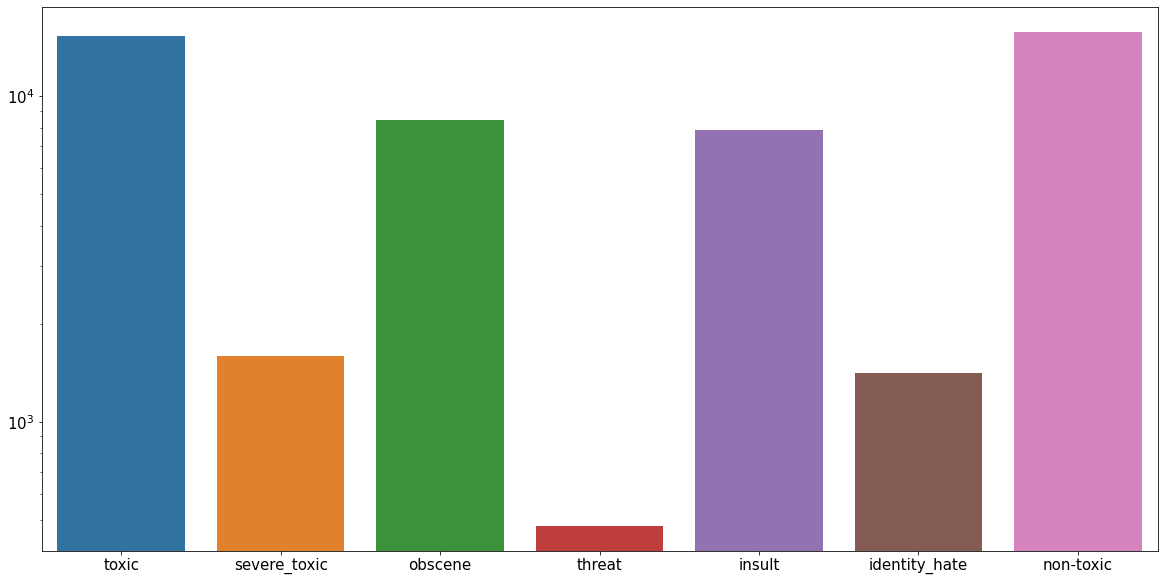

In [17]:
label_counts = train_balanced[target_columns+['non-toxic']].sum()
plt.figure(figsize=(20, 10))
ax = sns.barplot(x=label_counts.index, y=label_counts.values)
ax.set_yscale("log")
ax.tick_params(labelsize=15)


# Run pre-processing on comments

In [18]:
all_tokens = []
lemmas = []
nonstop_tokens = []
total_number_of_tokens = []
number_of_sentences = []
number_of_puncts = []
glove_vector = []


In [19]:

for doc in nlp.pipe(train_balanced['comment_text'].astype('unicode').values, batch_size=50):
    if doc.has_annotation("DEP"):
        all_tokens.append([t.lower_ for t in doc])
        nonstop_tokens.append([t.lower_ for t in doc if t.is_alpha and not t.is_stop])
        lemmas.append([t.lemma_ for t in doc if t.is_alpha and not t.is_stop])
        total_number_of_tokens.append(doc.__len__())
        number_of_sentences.append(sum(1 for _ in doc.sents))
        number_of_puncts.append(sum(1 for t in doc if t.is_punct))
        number_of_puncts.append(sum(1 for t in doc if t.is_punct))
        glove_vector.append(doc.vector.tolist())
    else:
        all_tokens.append(None)
        nonstop_tokens.append(None)
        lemmas.append(None)
        total_number_of_tokens.append(None)
        number_of_sentences.append(None)
        number_of_puncts.append(None)
        glove_vector.append(None)



In [20]:
train_balanced['all_tokens'] = all_tokens
train_balanced['nonstop_tokens'] = nonstop_tokens
train_balanced['lemmas'] = lemmas
train_balanced['total_number_of_tokens'] = total_number_of_tokens
train_balanced['number_of_sentences'] = number_of_sentences
train_balanced['number_of_puncts'] = number_of_puncts
train_balanced['glove_vector'] = glove_vector

# Analyse comments

In [24]:
length = train_balanced['total_number_of_tokens']
length.hist(bins=100);

KeyError: 'total_number_of_tokens'

In [ ]:
mc_length = []

for label in analysis_columns:
    mc_length.append(train_balanced.loc[train_balanced[label]==1,'number_of_sentences'].median())

plt.figure(figsize=(20, 10))
ax = sns.barplot(x=analysis_columns, y=mc_length)
ax.tick_params(labelsize=15)

In [ ]:
mc_length = []

for label in analysis_columns:
    mc_length.append(train_balanced.loc[train_balanced[label]==1,'total_number_of_tokens'].median())

plt.figure(figsize=(20, 10))
ax = sns.barplot(x=analysis_columns, y=mc_length)
ax.tick_params(labelsize=15)

In [25]:
log_max = np.log(train_balanced['total_number_of_tokens'].max())
train_balanced['log_tokens'] = train_balanced['total_number_of_tokens']**(1/log_max)
upper = train_balanced['log_tokens'].max()
train_balanced

KeyError: 'total_number_of_tokens'

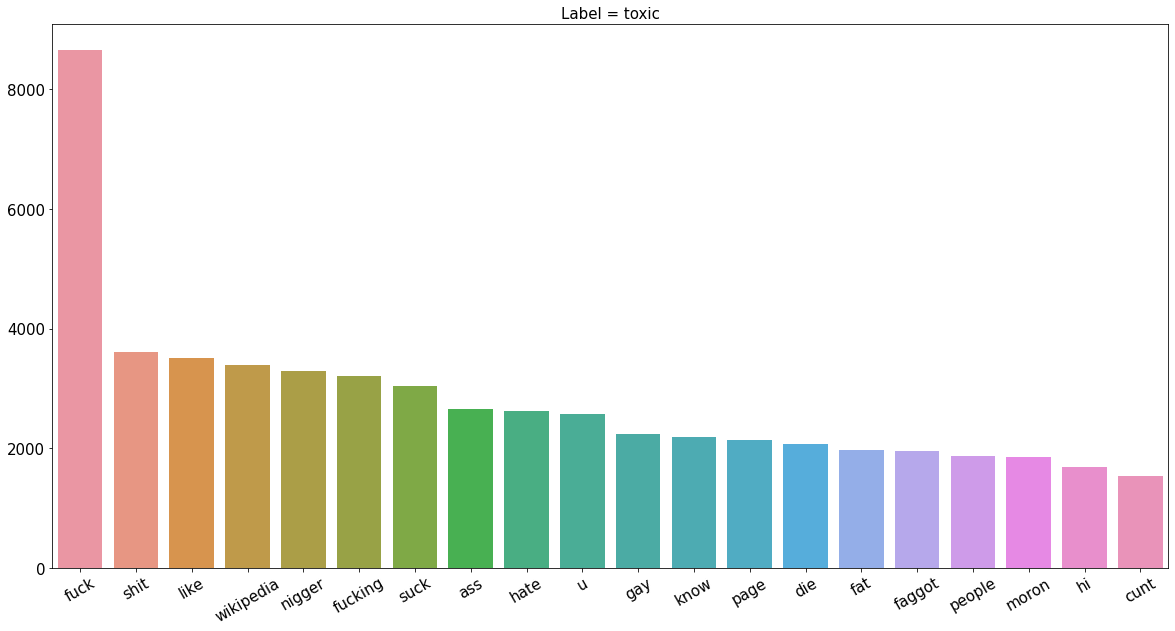

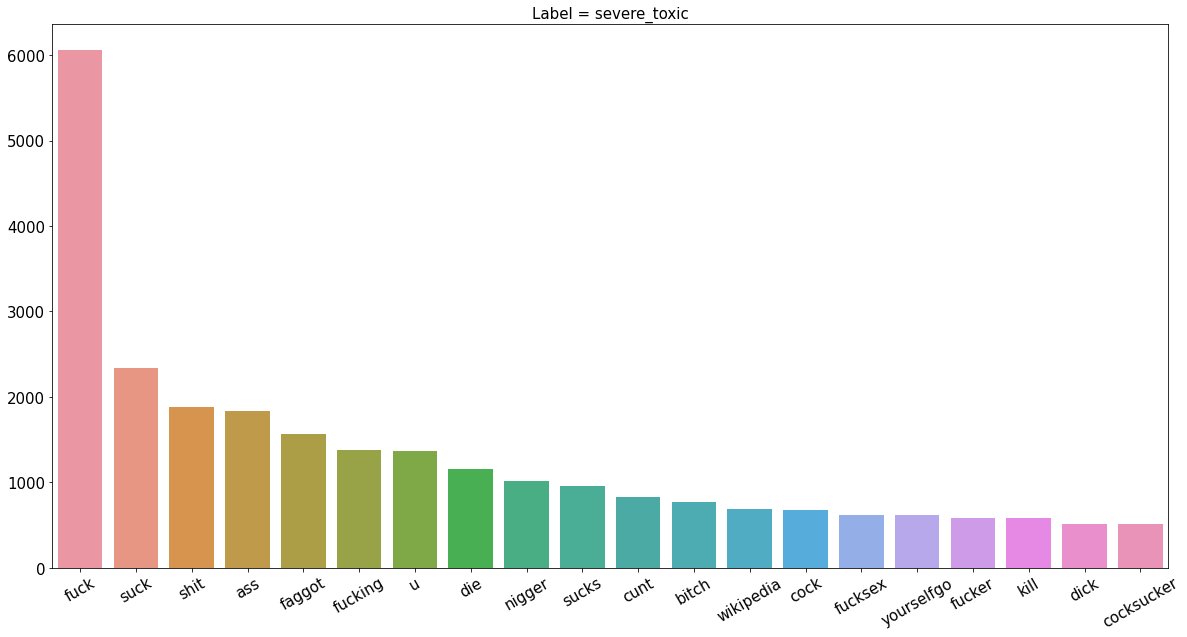

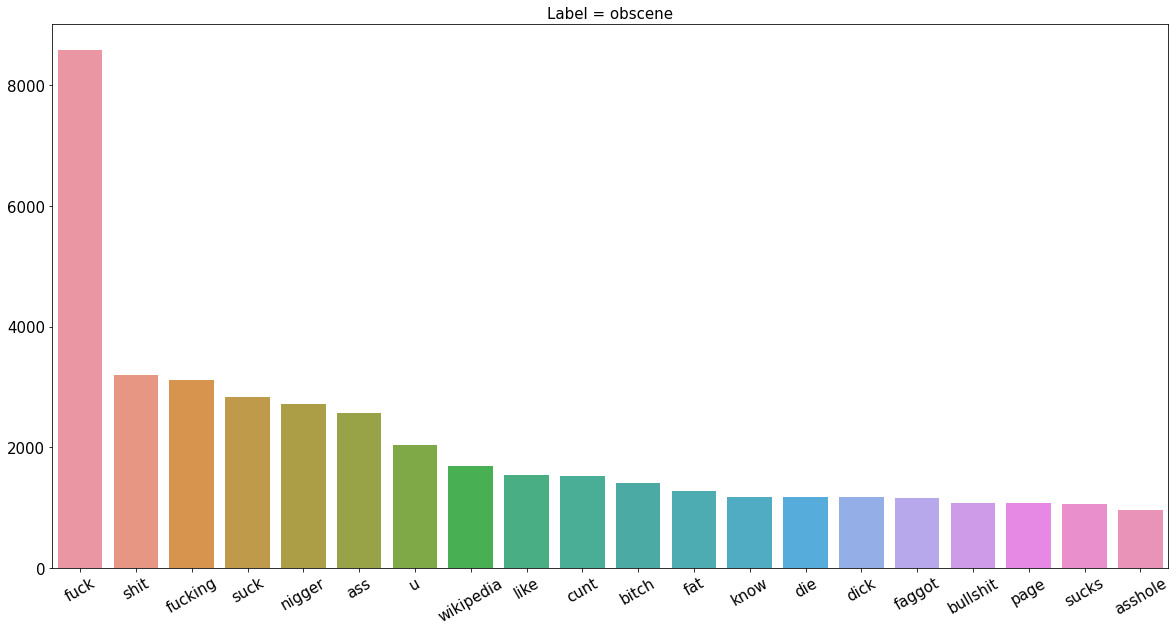

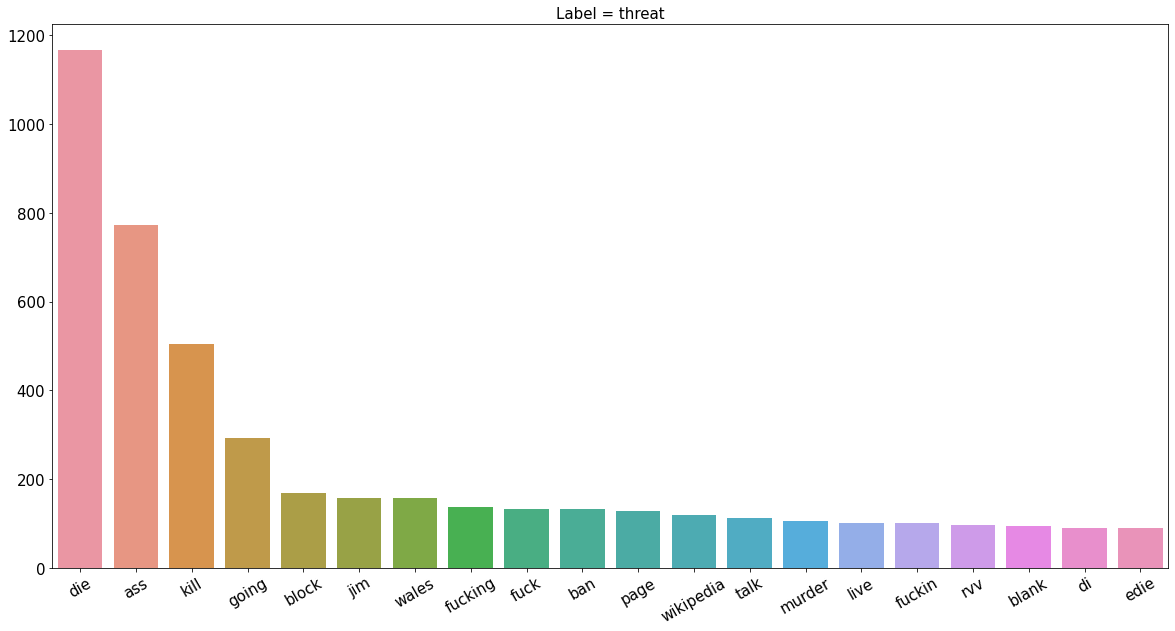

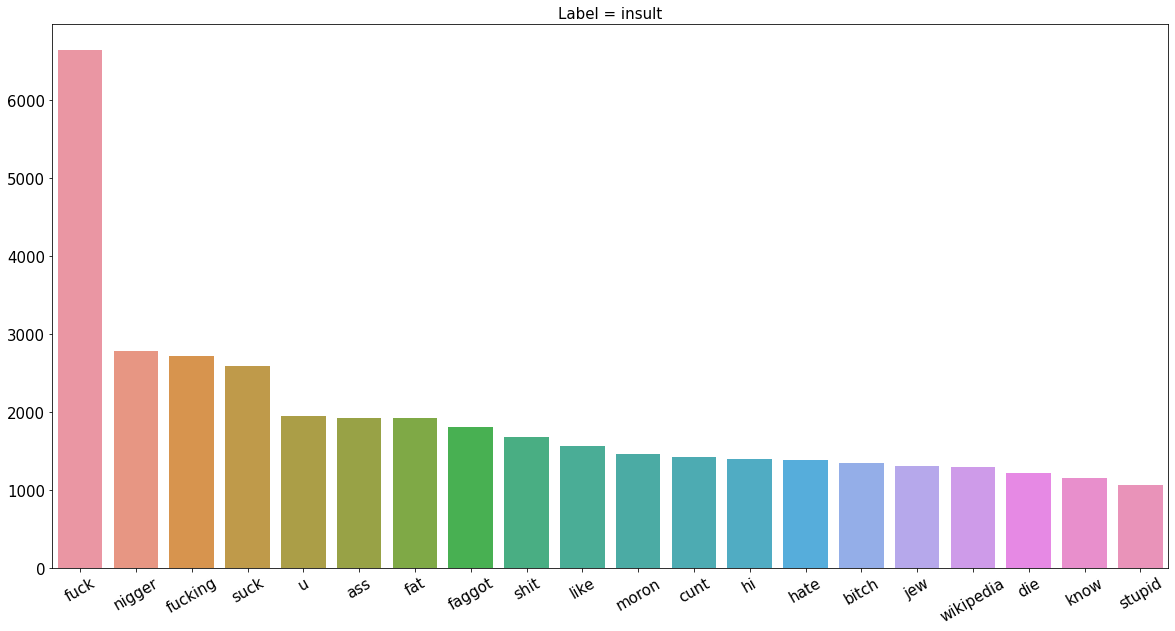

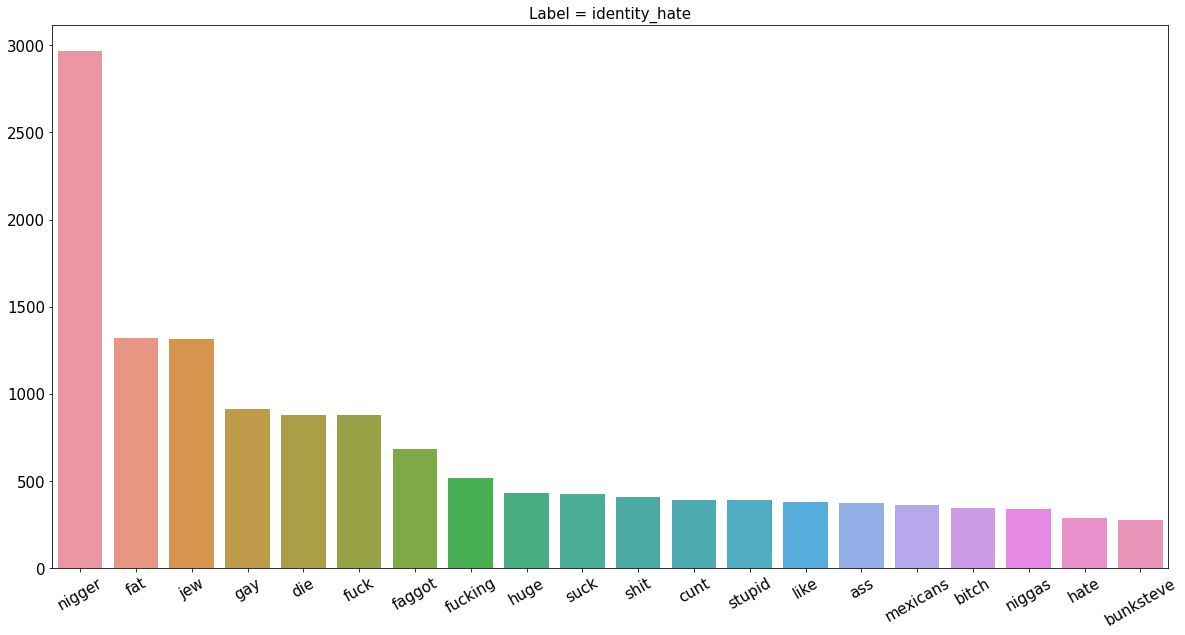

In [27]:
for label in target_columns:
    word_list = list(train_balanced.loc[train_balanced[label]==1, 'nonstop_tokens'].explode())
    most_common = collections.Counter(word_list).most_common(20)
    words = [w for w,_ in most_common]
    counts = [c for _,c in most_common]
    plt.figure(figsize=(20, 10))
    ax = sns.barplot(x=words, y=counts)
    ax.set_title(f'Label = {label}', fontsize=15)
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)

# Split into train/validation sets for analysis purposes

In [28]:
val_border = int(len(train_balanced)*0.6)
validation_set = train_balanced[val_border:].copy()

In [29]:
compare_set = ['toxic', 'insult', 'obscene']

# Prepare TF-IDF vectors

In [30]:
vectorizer = TfidfVectorizer(ngram_range=(1, 5), max_features=5000)
vectorizer.fit(train_balanced['comment_text'])
vectorizer


TfidfVectorizer(max_features=5000, ngram_range=(1, 5))

In [31]:
vectorizer.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 5000,
 'min_df': 1,
 'ngram_range': (1, 5),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [23]:
x_train = vectorizer.transform(train_balanced['comment_text'])

NameError: name 'vectorizer' is not defined

# Analyse three classifiers with two different encodings (TF-IDF and Glove)

In [33]:
lr_classifier = LogisticRegression(solver='liblinear')
average_roc = 0
    
for label in target_columns:
    lr_classifier.fit(x_train[:val_border], train_balanced[label][:val_border])
    predictions = lr_classifier.predict(x_train[val_border:])
    print(f'Label = {label}')
    print(classification_report(validation_set[label], predictions))
    print(f'AUC: {roc_auc_score(validation_set[label], predictions)}')
    average_roc += roc_auc_score(validation_set[label], predictions)
                                 
print(f'Average AUC: {average_roc/len(target_columns)}\n\n')

Label = toxic
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      6708
           1       0.88      0.85      0.86      6090

    accuracy                           0.87     12798
   macro avg       0.87      0.87      0.87     12798
weighted avg       0.87      0.87      0.87     12798

AUC: 0.8691505767688606
Label = severe_toxic
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     12164
           1       0.59      0.17      0.27       634

    accuracy                           0.95     12798
   macro avg       0.77      0.58      0.62     12798
weighted avg       0.94      0.95      0.94     12798

AUC: 0.5836268162660257
Label = obscene
              precision    recall  f1-score   support

           0       0.89      0.97      0.93      9451
           1       0.89      0.65      0.75      3347

    accuracy                           0.89     12798
   macro avg       0.89      

In [21]:
lr_classifier = LogisticRegression(solver='liblinear')
average_roc = 0
    
for label in target_columns:
    lr_classifier.fit(train_balanced['glove_vector'].to_list()[:val_border], train_balanced[label][:val_border])
    predictions = lr_classifier.predict(train_balanced['glove_vector'].to_list()[val_border:])
    print(f'Label = {label}')
    print(classification_report(validation_set[label], predictions))
    print(f'AUC: {roc_auc_score(validation_set[label], predictions)}')
    average_roc += roc_auc_score(validation_set[label], predictions)
                                 
print(f'Average AUC: {average_roc/len(target_columns)}\n\n')

In [22]:
sv_classifier = SVC()
average_roc = 0
    
for label in target_columns:
    sv_classifier.fit(x_train[:val_border], train_balanced[label][:val_border])
    predictions = sv_classifier.predict(x_train[val_border:])
    print(f'Label = {label}')
    print(classification_report(validation_set[label], predictions))
    print(f'AUC: {roc_auc_score(validation_set[label], predictions)}')
    average_roc += roc_auc_score(validation_set[label], predictions)
                                 
print(f'Average AUC: {average_roc/len(target_columns)}\n\n')

NameError: name 'x_train' is not defined

In [ ]:
sv_classifier = SVC()
average_roc = 0
    
for label in target_columns:
    sv_classifier.fit(train_balanced['glove_vector'].to_list()[:val_border], train_balanced[label][:val_border])
    predictions = sv_classifier.predict(train_balanced['glove_vector'].to_list()[val_border:])
    #probabilities = sv_classifier.predict_proba(train_balanced['glove_vector'].to_list()[val_border:])[:,1]
    print(f'Label = {label}')
    print(classification_report(validation_set[label], predictions))
    print(f'AUC: {roc_auc_score(validation_set[label], predictions)}')
    average_roc += roc_auc_score(validation_set[label], predictions)
                                 
print(f'Average AUC: {average_roc/len(target_columns)}\n\n')

In [ ]:
# Multi-Layer Perceptron Classifier based on TF-IDF

mlp_classifier = MLPClassifier(max_iter=500)
average_roc = 0
    
for label in target_columns:
    mlp_classifier.fit(x_train[:val_border], train_balanced[label][:val_border])
    predictions = mlp_classifier.predict(x_train[val_border:])
    print(f'Label = {label}')
    print(classification_report(validation_set[label], predictions))
    print(f'AUC: {roc_auc_score(validation_set[label], predictions)}')
    average_roc += roc_auc_score(validation_set[label], predictions)
                                 
print(f'Average AUC: {average_roc/len(target_columns)}\n\n')

In [ ]:
# Multi-Layer Perceptron Classifier based on Glove

mlp_classifier = MLPClassifier(max_iter=500)
average_roc = 0
    
for label in target_columns:
    mlp_classifier.fit(train_balanced['glove_vector'].to_list()[:val_border], train_balanced[label][:val_border])
    predictions = mlp_classifier.predict(train_balanced['glove_vector'].to_list()[val_border:])
    print(f'Label = {label}')
    print(classification_report(validation_set[label], predictions))
    print(f'AUC: {roc_auc_score(validation_set[label], predictions)}')
    average_roc += roc_auc_score(validation_set[label], predictions)
                                 
print(f'Average AUC: {average_roc/len(target_columns)}\n\n')

In [ ]:
# Multi-Layer Perceptron Classifier based on Glove

mlp_classifier = MLPClassifier(max_iter=1000)
    

mlp_classifier.fit(train_balanced['glove_vector'].to_list()[:val_border], train_balanced[target_columns][:val_border])
predictions = mlp_classifier.predict(train_balanced['glove_vector'].to_list()[val_border:])
probabilities = mlp_classifier.predict_proba(train_balanced['glove_vector'].to_list()[val_border:])

average_roc = 0
i = 0
for label in target_columns:
    print(f'Label = {label}')
    prediction = [p[i] for p in predictions]
    probability = [p[i] for p in probabilities]
    print(classification_report(validation_set[label], prediction))
    print(f'AUC: {roc_auc_score(validation_set[label], prediction)}\n\n')
    average_roc += roc_auc_score(validation_set[label], prediction)
    i += 1
    
print(f'Average AUC: {average_roc/len(target_columns)}\n\n')

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=10000, min_df=2, max_df=0.7)
vectorizer.fit(train['comment_text'])
vectorizer.get_params()

In [ ]:
x_train = vectorizer.transform(train['comment_text'])
x_test = vectorizer.transform(test['comment_text'])

In [ ]:
# Logistic Regression with linear solver

lr_classifier = LogisticRegression(solver='liblinear')
    
for label in target_columns:
    lr_classifier.fit(x_train, train[label])
    test[label] = lr_classifier.predict_proba(x_test)[:,1]

In [ ]:
test.head()

In [ ]:
test[sample.columns.to_list()].to_csv('mlp_submission.csv', index=False)